# GPyTorch Regression Tutorial

## Introduction

In this notebook, we demonstrate many of the design features of GPyTorch using the simplest example, training an RBF kernel Gaussian process on a simple function. We'll be modeling the function

\begin{align}
y &= \sin(2\pi x) + \epsilon \\
  \epsilon &\sim \mathcal{N}(0, 0.04) 
\end{align}

with 100 training examples, and testing on 51 test examples.

**Note:** this notebook is not necessarily intended to teach the mathematical background of Gaussian processes, but rather how to train a simple one and make predictions in GPyTorch. For a mathematical treatment, Chapter 2 of Gaussian Processes for Machine Learning provides a very thorough introduction to GP regression (this entire text is highly recommended): http://www.gaussianprocess.org/gpml/chapters/RW2.pdf

In [1]:
import math
import torch
import gpytorch
from matplotlib import pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

### Set up training data

In the next cell, we set up the training data for this example. We'll be using 100 regularly spaced points on [0,1] which we evaluate the function on and add Gaussian noise to get the training labels.

In [2]:
# Training data is 100 points in [0,1] inclusive regularly spaced
train_x = torch.linspace(0., 3., 15)
# True function is sin(2*pi*x) with Gaussian noise
train_y = torch.sin(train_x / 3. * (2 * math.pi)) + torch.randn(train_x.size()) * math.sqrt(0.04)

## Setting up the model

The next cell demonstrates the most critical features of a user-defined Gaussian process model in GPyTorch. Building a GP model in GPyTorch is different in a number of ways.

First in contrast to many existing GP packages, we do not provide full GP models for the user. Rather, we provide *the tools necessary to quickly construct one*. This is because we believe, analogous to building a neural network in standard PyTorch, it is important to have the flexibility to include whatever components are necessary. As can be seen in more complicated examples, this allows the user great flexibility in designing custom models.

For most GP regression models, you will need to construct the following GPyTorch objects:

1. A **GP Model** (`gpytorch.models.ExactGP`) -  This handles most of the inference.
1. A **Likelihood** (`gpytorch.likelihoods.GaussianLikelihood`) - This is the most common likelihood used for GP regression.
1. A **Mean** - This defines the prior mean of the GP.(If you don't know which mean to use, a `gpytorch.means.ConstantMean()` is a good place to start.)
1. A **Kernel** - This defines the prior covariance of the GP.(If you don't know which kernel to use, a `gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())` is a good place to start).
1. A **MultivariateNormal** Distribution (`gpytorch.distributions.MultivariateNormal`) - This is the object used to represent multivariate normal distributions.
  
  
### The GP Model
  
The components of a user built (Exact, i.e. non-variational) GP model in GPyTorch are, broadly speaking:

1. An `__init__` method that takes the training data and a likelihood, and constructs whatever objects are necessary for the model's `forward` method. This will most commonly include things like a mean module and a kernel module.

2. A `forward` method that takes in some $n \times d$ data `x` and returns a `MultivariateNormal` with the *prior* mean and covariance evaluated at `x`. In other words, we return the vector $\mu(x)$ and the $n \times n$ matrix $K_{xx}$ representing the prior mean and covariance matrix of the GP. 

This specification leaves a large amount of flexibility when defining a model. For example, to compose two kernels via addition, you can either add the kernel modules directly:

```python
self.covar_module = ScaleKernel(RBFKernel() + WhiteNoiseKernel())
```

Or you can add the outputs of the kernel in the forward method:

```python
covar_x = self.rbf_kernel_module(x) + self.white_noise_module(x)
```

In [3]:
# We will use the simplest form of GP model, exact inference
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.WLSHKernel(num_samples=100, num_dims=1))
    
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(train_x, train_y, likelihood)

### Model modes

Like most PyTorch modules, the `ExactGP` has a `.train()` and `.eval()` mode.
- `.train()` mode is for optimizing model hyperameters.
- `.eval()` mode is for computing predictions through the model posterior.

## Training the model

In the next cell, we handle using Type-II MLE to train the hyperparameters of the Gaussian process.

The most obvious difference here compared to many other GP implementations is that, as in standard PyTorch, the core training loop is written by the user. In GPyTorch, we make use of the standard PyTorch optimizers as from `torch.optim`, and all trainable parameters of the model should be of type `torch.nn.Parameter`. Because GP models directly extend `torch.nn.Module`, calls to methods like `model.parameters()` or `model.named_parameters()` function as you might expect coming from PyTorch.

In most cases, the boilerplate code below will work well. It has the same basic components as the standard PyTorch training loop:

1. Zero all parameter gradients
2. Call the model and compute the loss
3. Call backward on the loss to fill in gradients
4. Take a step on the optimizer

However, defining custom training loops allows for greater flexibility. For example, it is easy to save the parameters at each step of training, or use different learning rates for different parameters (which may be useful in deep kernel learning for example).

In [4]:
# this is for running the notebook in our testing framework
import os
smoke_test = ('CI' in os.environ)
training_iter = 2 if smoke_test else 50


# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

with gpytorch.settings.max_cholesky_size(0), gpytorch.settings.lazily_evaluate_kernels(False):
    for i in range(training_iter):
        # Zero gradients from previous iteration
        optimizer.zero_grad()
        # Output from model
        output = model(train_x)
        # Calc loss and backprop gradients
        loss = -mll(output, train_y)
        loss.backward()
        print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   os: %.3f    noise: %.3f' % (
            i + 1, training_iter, loss.item(),
            model.covar_module.base_kernel.lengthscale.item(),
            model.covar_module.outputscale.item(),
            model.likelihood.noise.item()
        ))
        optimizer.step()

Iter 1/50 - Loss: 1.044   lengthscale: 0.693   os: 0.693    noise: 0.693
Iter 2/50 - Loss: 1.062   lengthscale: 0.644   os: 0.644    noise: 0.644
Iter 3/50 - Loss: 0.937   lengthscale: 0.605   os: 0.598    noise: 0.598
Iter 4/50 - Loss: 0.965   lengthscale: 0.609   os: 0.561    noise: 0.554
Iter 5/50 - Loss: 0.925   lengthscale: 0.627   os: 0.524    noise: 0.513
Iter 6/50 - Loss: 0.871   lengthscale: 0.654   os: 0.491    noise: 0.474
Iter 7/50 - Loss: 0.869   lengthscale: 0.678   os: 0.464    noise: 0.437
Iter 8/50 - Loss: 0.827   lengthscale: 0.677   os: 0.442    noise: 0.403
Iter 9/50 - Loss: 0.839   lengthscale: 0.663   os: 0.425    noise: 0.371
Iter 10/50 - Loss: 0.796   lengthscale: 0.639   os: 0.412    noise: 0.341
Iter 11/50 - Loss: 0.759   lengthscale: 0.614   os: 0.407    noise: 0.313
Iter 12/50 - Loss: 0.789   lengthscale: 0.599   os: 0.407    noise: 0.287
Iter 13/50 - Loss: 0.767   lengthscale: 0.584   os: 0.410    noise: 0.264
Iter 14/50 - Loss: 0.723   lengthscale: 0.570  

In [5]:
model.eval()
with gpytorch.settings.prior_mode(), gpytorch.settings.max_cholesky_size(0):
    print(model(train_x).covariance_matrix)

tensor([[0.2806, 0.2415, 0.1877, 0.1365, 0.1100, 0.0806, 0.0590, 0.0453, 0.0312,
         0.0189, 0.0126, 0.0080, 0.0035, 0.0013, 0.0010],
        [0.2415, 0.2957, 0.2604, 0.2092, 0.1667, 0.1258, 0.0947, 0.0710, 0.0461,
         0.0268, 0.0186, 0.0125, 0.0061, 0.0029, 0.0025],
        [0.1877, 0.2604, 0.3059, 0.2804, 0.2371, 0.1872, 0.1414, 0.1066, 0.0674,
         0.0345, 0.0234, 0.0156, 0.0079, 0.0042, 0.0038],
        [0.1365, 0.2092, 0.2804, 0.3397, 0.3092, 0.2568, 0.2015, 0.1559, 0.0993,
         0.0512, 0.0326, 0.0195, 0.0094, 0.0056, 0.0052],
        [0.1100, 0.1667, 0.2371, 0.3092, 0.3414, 0.3072, 0.2496, 0.2015, 0.1267,
         0.0735, 0.0458, 0.0260, 0.0130, 0.0082, 0.0077],
        [0.0806, 0.1258, 0.1872, 0.2568, 0.3072, 0.3426, 0.2993, 0.2506, 0.1580,
         0.1029, 0.0678, 0.0414, 0.0211, 0.0119, 0.0110],
        [0.0590, 0.0947, 0.1414, 0.2015, 0.2496, 0.2993, 0.3242, 0.2935, 0.1982,
         0.1386, 0.0911, 0.0575, 0.0307, 0.0178, 0.0160],
        [0.0453, 0.0710, 0.

## Make predictions with the model

In the next cell, we make predictions with the model. To do this, we simply put the model and likelihood in eval mode, and call both modules on the test data.

Just as a user defined GP model returns a `MultivariateNormal` containing the prior mean and covariance from forward, a trained GP model in eval mode returns a `MultivariateNormal` containing the posterior mean and covariance. Thus, getting the predictive mean and variance, and then sampling functions from the GP at the given test points could be accomplished with calls like:

```python
f_preds = model(test_x)
y_preds = likelihood(model(test_x))

f_mean = f_preds.mean
f_var = f_preds.variance
f_covar = f_preds.covariance_matrix
f_samples = f_preds.sample(sample_shape=torch.Size(1000,))
```

The `gpytorch.settings.fast_pred_var` context is not needed, but here we are giving a preview of using one of our cool features, getting faster predictive distributions using [LOVE](https://arxiv.org/abs/1803.06058).

In [6]:
# Get into evaluation (predictive posterior) mode
model.eval()
likelihood.eval()

# Test points are regularly spaced along [0,1]
# Make predictions by feeding model through likelihood
with torch.no_grad(), gpytorch.settings.fast_pred_var(), gpytorch.settings.max_cholesky_size(0):
    with gpytorch.settings.lazily_evaluate_kernels(False):
        test_x = torch.linspace(2, 6, 51)
        observed_pred = likelihood(model(test_x))

## Plot the model fit

In the next cell, we plot the mean and confidence region of the Gaussian process model. The `confidence_region` method is a helper method that returns 2 standard deviations above and below the mean.

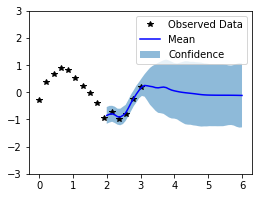

In [7]:
with torch.no_grad():
    # Initialize plot
    f, ax = plt.subplots(1, 1, figsize=(4, 3))

    # Get upper and lower confidence bounds
    lower, upper = observed_pred.confidence_region()
    # Plot training data as black stars
    ax.plot(train_x.numpy(), train_y.numpy(), 'k*')
    # Plot predictive means as blue line
    ax.plot(test_x.numpy(), observed_pred.mean.numpy(), 'b')
    # Shade between the lower and upper confidence bounds
    ax.fill_between(test_x.numpy(), lower.numpy(), upper.numpy(), alpha=0.5)
    ax.set_ylim([-3, 3])
    ax.legend(['Observed Data', 'Mean', 'Confidence'])